In [1]:
#@title Dataset Definition

"""Smart Buildings Dataset implementation, including loading and downloading."""


import json
import pickle
import shutil
import numpy as np
import requests





class SmartBuildingsDataset:
 """Smart Buildings Dataset implementation, including loading and downloading."""


 def __init__(self, download=True):
   self.partitions = {
       "sb1": [
           "2022_a",
           "2022_b",
           "2023_a",
           "2023_b",
           "2024_a",
       ],
   }
   if download:
     self.download()


 def download(self):
   """Downloads the Smart Buildings Dataset from Google Cloud Storage."""
   print("Downloading data...")


   def download_file(url):
     local_filename = url.split("/")[-1]
     with requests.get(url, stream=True) as r:
       r.raise_for_status()
       with open(local_filename, "wb") as f:
         for chunk in r.iter_content(chunk_size=8192):
           f.write(chunk)
     return local_filename


   url = "https://storage.googleapis.com/gresearch/smart_buildings_dataset/tabular_data/sb1.zip"
   download_file(url)
   shutil.unpack_archive("sb1.zip", "sb1/")


 def get_floorplan(self, building):
   """Gets the floorplan and device layout map for a specific building.


   Args:
     building: The name of the building.


   Returns:
     A tuple containing the floorplan and device layout map.
   """
   if building not in self.partitions.keys():
     raise ValueError("invalid building")
   floorplan = np.load(f"./{building}/tabular/floorplan.npy")

   def gdrive_to_direct_url(share_url):
        file_id = share_url.split('/d/')[1].split('/')[0]
        return f"https://drive.google.com/uc?export=download&id={file_id}"
   share_url = "https://drive.google.com/file/d/19W4exC1IfIpx6x_agZy3HO1ARXdxKnic/view?usp=sharing"
   direct_url = gdrive_to_direct_url(share_url)
   response = requests.get(direct_url)
   device_layout_map = response.json()

   return floorplan, device_layout_map


 def get_building_data(self, building, partition):
   """Gets the data for a specific building and partition.


   Args:
     building: The name of the building.
     partition: The name of the partition.


   Returns:
     A tuple containing the data and metadata.
   """
   if building not in self.partitions.keys():
     raise ValueError("invalid building")
   if partition not in self.partitions[building]:
     raise ValueError("invalid partition")
   path = f"./{building}/tabular/{building}/{partition}/"


   data = np.load(path + "data.npy.npz")
   metadata = pickle.load(open(path + "metadata.pickle", "rb"))


   if "device_infos" not in metadata.keys():
     metadata["device_infos"] = pickle.load(
         open(f"./{building}/tabular/device_info_dicts.pickle", "rb")
     )
   if "zone_infos" not in metadata.keys():
     metadata["zone_infos"] = pickle.load(
         open(f"./{building}/tabular/zone_info_dicts.pickle", "rb")
     )
   return data, metadata


In [2]:
#@title Data download and splitting

ds = SmartBuildingsDataset()

# training data: Jan-June 2022
data, metadata = ds.get_building_data("sb1","2022_a")
floorplan, device_layout_map = ds.get_floorplan("sb1")

# validation data: July-December 2022
data_val, metadata_val = ds.get_building_data("sb1","2022_b")
floorplan_val, device_layout_map_val = ds.get_floorplan("sb1")

# lets split validation data into things to predict, and exogenous variables
indexes = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data = data_val['observation_value_matrix'][:, indexes]
matching_items = [(k, v) for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data_ids = {k: i for i, (k, v) in enumerate(matching_items)}

indexes = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
exogenous_observation_data = data_val['observation_value_matrix'][:, indexes]
matching_items = [(k, v) for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
exogenous_observation_data_ids = {k: i for i, (k, v) in enumerate(matching_items)}

initial_condition = temp_data[0]

In [3]:
# Train data:
data['observation_value_matrix']
metadata["observation_ids"]
metadata["observation_timestamps"]

data['action_value_matrix']
metadata["action_ids"]

floorplan
device_layout_map
metadata["device_infos"]

# Validation data:
data_val['action_value_matrix']
metadata_val["action_ids"]
metadata_val["observation_timestamps"]
floorplan
device_layout_map

exogenous_observation_data
exogenous_observation_data_ids
initial_condition

# Predict:
temp_data
temp_data_ids







{'2760348383893915@zone_air_temperature_sensor': 0,
 '2562701969438717@zone_air_temperature_sensor': 1,
 '2806035809406684@zone_air_temperature_sensor': 2,
 '2790439929052995@zone_air_temperature_sensor': 3,
 '2628534928204590@zone_air_temperature_sensor': 4,
 '2535333053617205@zone_air_temperature_sensor': 5,
 '2619255661594253@zone_air_temperature_sensor': 6,
 '2618781414146613@zone_air_temperature_sensor': 7,
 '2613654138967436@zone_air_temperature_sensor': 8,
 '2762982574975969@zone_air_temperature_sensor': 9,
 '2578499186529204@zone_air_temperature_sensor': 10,
 '2693289483686059@zone_air_temperature_sensor': 11,
 '2549483694528743@zone_air_temperature_sensor': 12,
 '2614466029028994@zone_air_temperature_sensor': 13,
 '2760979770441910@zone_air_temperature_sensor': 14,
 '2732460999450017@zone_air_temperature_sensor': 15,
 '2549513081490212@zone_air_temperature_sensor': 16,
 '2737293899563066@zone_air_temperature_sensor': 17,
 '2710040674126014@zone_air_temperature_sensor': 18,
 '2

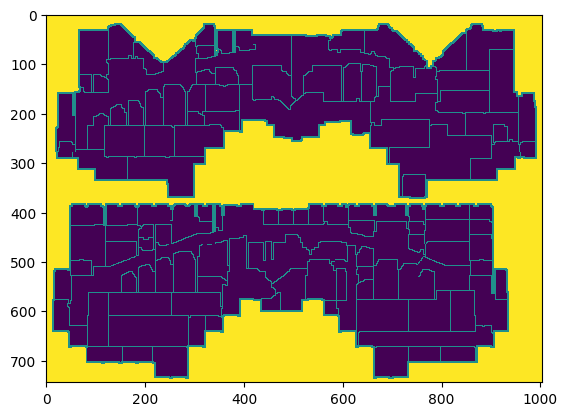

In [4]:
from matplotlib import pyplot as plt
plt.imshow(floorplan, interpolation='nearest')
plt.show()

In [5]:
metadata["device_infos"][0]


{'device_id': '202194278473007104',
 'namespace': 'PHRED',
 'code': 'SB1:AHU:AC-2',
 'zone_id': '',
 'device_type': 6,
 'observable_fields': {'building_air_static_pressure_sensor': 1,
  'outside_air_flowrate_sensor': 1,
  'supply_fan_speed_percentage_command': 1,
  'supply_air_temperature_sensor': 1,
  'supply_fan_speed_frequency_sensor': 1,
  'supply_air_static_pressure_setpoint': 1,
  'return_air_temperature_sensor': 1,
  'mixed_air_temperature_setpoint': 1,
  'exhaust_fan_speed_percentage_command': 1,
  'exhaust_fan_speed_frequency_sensor': 1,
  'outside_air_damper_percentage_command': 1,
  'mixed_air_temperature_sensor': 1,
  'exhaust_air_damper_percentage_command': 1,
  'cooling_percentage_command': 1,
  'outside_air_flowrate_setpoint': 1,
  'supply_air_temperature_setpoint': 1,
  'building_air_static_pressure_setpoint': 1,
  'supply_air_static_pressure_sensor': 1},
 'action_fields': {'exhaust_air_damper_percentage_command': 1,
  'supply_air_temperature_setpoint': 1,
  'supply_fan

In [6]:
metadata["zone_infos"][0]


{'zone_id': 'rooms/1002000133978',
 'building_id': 'buildings/3616672508',
 'zone_description': 'SB1-2-C2054',
 'area': 0.0,
 'zone_type': 1,
 'floor': 2,
 'devices': ['2618581107144046', '2696593986887004']}

In [7]:
temp_data.shape

(53292, 123)

In [8]:
print((temp_data==0).sum()/(temp_data.shape[0]*temp_data.shape[1]))

0.10406372865800263


In [9]:
indexes1 = [v for k, v in metadata['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data_train = data['observation_value_matrix'][:, indexes1]

(temp_data_train==0).sum()/(temp_data_train.shape[0]*temp_data_train.shape[1])

0.28568066460576663

In [10]:
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

def kelvin_to_fahrenheit(temp_k):
    """Convert temperature from Kelvin to Fahrenheit"""
    return (temp_k - 273.15) * 9/5 + 32

def preprocess_temperatures(data_matrix, metadata_dict, data_name="data"):
    """
    Preprocess temperature data by converting Kelvin to Fahrenheit
    
    Args:
        data_matrix: numpy array of observation data
        metadata_dict: dictionary containing observation_ids mapping
        data_name: string name for logging purposes

    Returns:
        data_matrix: preprocessed data matrix (modified in-place)
        temp_conversion_info: dictionary with conversion statistics
    """
    
    print(f"\n=== Temperature Preprocessing for {data_name} ===")
    
    # Find temperature-related observation IDs
    temp_sensor_ids = []
    temp_setpoint_ids = []
    
    for obs_name, obs_idx in metadata_dict.items():
        if any(temp_keyword in obs_name.lower() for temp_keyword in [
            'temperature_sensor', 'temperature_setpoint', 
            'air_temperature', 'mixed_air_temperature',
            'supply_air_temperature', 'return_air_temperature',
            'discharge_air_temperature', 'outside_air_temperature'
        ]):
            if 'sensor' in obs_name:
                temp_sensor_ids.append((obs_name, obs_idx))
            elif 'setpoint' in obs_name:
                temp_setpoint_ids.append((obs_name, obs_idx))
            else:
                # Default to sensor if unclear
                temp_sensor_ids.append((obs_name, obs_idx))
    
    print(f"Found {len(temp_sensor_ids)} temperature sensors")
    print(f"Found {len(temp_setpoint_ids)} temperature setpoints")
    
    conversion_info = {
        'sensors_converted': 0,
        'setpoints_converted': 0,
        'total_values_converted': 0,
        'sensor_details': [],
        'setpoint_details': []
    }
    
    # Process temperature sensors
    for obs_name, obs_idx in temp_sensor_ids:
        temp_values = data_matrix[:, obs_idx]
        
        # Find values that might be in Kelvin (> 273)
        kelvin_mask = temp_values > 273
        kelvin_count = np.sum(kelvin_mask)
        
        if kelvin_count > 0:
            print(f"  Converting {kelvin_count}/{len(temp_values)} values in {obs_name}")
            print(f"    Before: min={temp_values[kelvin_mask].min():.2f}, max={temp_values[kelvin_mask].max():.2f}")
            
            # Convert Kelvin to Fahrenheit
            data_matrix[kelvin_mask, obs_idx] = kelvin_to_fahrenheit(temp_values[kelvin_mask])
            
            print(f"    After:  min={data_matrix[kelvin_mask, obs_idx].min():.2f}, max={data_matrix[kelvin_mask, obs_idx].max():.2f}")
            
            conversion_info['sensors_converted'] += 1
            conversion_info['total_values_converted'] += kelvin_count
            conversion_info['sensor_details'].append({
                'name': obs_name,
                'index': obs_idx,
                'values_converted': kelvin_count,
                'total_values': len(temp_values)
            })
    
    # Process temperature setpoints
    for obs_name, obs_idx in temp_setpoint_ids:
        temp_values = data_matrix[:, obs_idx]
        
        # Find values that might be in Kelvin (> 273)
        kelvin_mask = temp_values > 273
        kelvin_count = np.sum(kelvin_mask)
        
        if kelvin_count > 0:
            print(f"  Converting {kelvin_count}/{len(temp_values)} values in {obs_name}")
            print(f"    Before: min={temp_values[kelvin_mask].min():.2f}, max={temp_values[kelvin_mask].max():.2f}")
            
            # Convert Kelvin to Fahrenheit
            data_matrix[kelvin_mask, obs_idx] = kelvin_to_fahrenheit(temp_values[kelvin_mask])
            
            print(f"    After:  min={data_matrix[kelvin_mask, obs_idx].min():.2f}, max={data_matrix[kelvin_mask, obs_idx].max():.2f}")
            
            conversion_info['setpoints_converted'] += 1
            conversion_info['total_values_converted'] += kelvin_count
            conversion_info['setpoint_details'].append({
                'name': obs_name,
                'index': obs_idx,
                'values_converted': kelvin_count,
                'total_values': len(temp_values)
            })
    
    print(f"\nConversion Summary for {data_name}:")
    print(f"  Temperature sensors converted: {conversion_info['sensors_converted']}")
    print(f"  Temperature setpoints converted: {conversion_info['setpoints_converted']}")
    print(f"  Total values converted: {conversion_info['total_values_converted']}")
    
    return data_matrix, conversion_info

def preprocess_temp_data_array(temp_data_array, temp_data_ids, data_name="temperature data"):
    """
    Preprocess temperature data array (for validation temperature data)
    
    Args:
        temp_data_array: numpy array of temperature data
        temp_data_ids: dictionary mapping temperature sensor names to column indices
        data_name: string name for logging purposes

    Returns:
        temp_data_array: preprocessed temperature data (modified in-place)
        conversion_info: dictionary with conversion statistics
    """
    
    print(f"\n=== Temperature Preprocessing for {data_name} ===")
    
    conversion_info = {
        'sensors_converted': 0,
        'total_values_converted': 0,
        'sensor_details': []
    }
    
    for sensor_name, col_idx in temp_data_ids.items():
        temp_values = temp_data_array[:, col_idx]
        
        # Find values that might be in Kelvin (> 273)
        kelvin_mask = temp_values > 273
        kelvin_count = np.sum(kelvin_mask)
        
        if kelvin_count > 0:
            print(f"  Converting {kelvin_count}/{len(temp_values)} values in {sensor_name}")
            print(f"    Before: min={temp_values[kelvin_mask].min():.2f}, max={temp_values[kelvin_mask].max():.2f}")
            
            # Convert Kelvin to Fahrenheit
            temp_data_array[kelvin_mask, col_idx] = kelvin_to_fahrenheit(temp_values[kelvin_mask])
            
            print(f"    After:  min={temp_data_array[kelvin_mask, col_idx].min():.2f}, max={temp_data_array[kelvin_mask, col_idx].max():.2f}")
            
            conversion_info['sensors_converted'] += 1
            conversion_info['total_values_converted'] += kelvin_count
            conversion_info['sensor_details'].append({
                'name': sensor_name,
                'index': col_idx,
                'values_converted': kelvin_count,
                'total_values': len(temp_values)
            })
    
    print(f"\nConversion Summary for {data_name}:")
    print(f"  Temperature sensors converted: {conversion_info['sensors_converted']}")
    print(f"  Total values converted: {conversion_info['total_values_converted']}")
    
    return temp_data_array, conversion_info

def remove_zero_temperature_readings(obs_matrix, temp_data_matrix, exog_data_matrix, 
                                   timestamps_train, timestamps_val, metadata_obs_ids, 
                                   temp_data_ids, exog_data_ids):
    """
    Remove rows where temperature sensors have zero values from both training and validation sets
    
    Args:
        obs_matrix: training observation matrix
        temp_data_matrix: validation temperature data matrix  
        exog_data_matrix: validation exogenous data matrix
        timestamps_train: training timestamps
        timestamps_val: validation timestamps
        metadata_obs_ids: training observation IDs mapping
        temp_data_ids: validation temperature IDs mapping
        exog_data_ids: validation exogenous IDs mapping

    Returns:
        Cleaned datasets with zero temperature readings removed
    """
    
    print("\n" + "="*60)
    print("REMOVING ZERO TEMPERATURE READINGS")
    print("="*60)
    
    # 1. Clean training data
    print("\nCleaning training data...")
    
    # Find temperature sensor columns in training data
    train_temp_indices = [v for k, v in metadata_obs_ids.items() 
                         if "zone_air_temperature_sensor" in k]
    
    # Get temperature data from training matrix
    train_temp_data = obs_matrix[:, train_temp_indices]
    
    # Find rows where ANY temperature sensor has zero values
    zero_mask_train = np.any(train_temp_data == 0, axis=1)
    valid_mask_train = ~zero_mask_train
    
    print(f"  Original training data: {len(obs_matrix)} rows")
    print(f"  Rows with zero temperatures: {np.sum(zero_mask_train)}")
    print(f"  Rows to keep: {np.sum(valid_mask_train)}")
    print(f"  Percentage kept: {np.sum(valid_mask_train)/len(obs_matrix)*100:.1f}%")
    
    # Apply mask to training data
    obs_matrix_clean = obs_matrix[valid_mask_train]
    timestamps_train_clean = [timestamps_train[i] for i in range(len(timestamps_train)) if valid_mask_train[i]]
    
    # 2. Clean validation data
    print("\nCleaning validation data...")
    
    # Find rows where ANY temperature sensor has zero values in validation
    zero_mask_val = np.any(temp_data_matrix == 0, axis=1)
    valid_mask_val = ~zero_mask_val
    
    print(f"  Original validation data: {len(temp_data_matrix)} rows")
    print(f"  Rows with zero temperatures: {np.sum(zero_mask_val)}")
    print(f"  Rows to keep: {np.sum(valid_mask_val)}")
    print(f"  Percentage kept: {np.sum(valid_mask_val)/len(temp_data_matrix)*100:.1f}%")
    
    # Apply mask to validation data
    temp_data_clean = temp_data_matrix[valid_mask_val]
    exog_data_clean = exog_data_matrix[valid_mask_val]
    timestamps_val_clean = [timestamps_val[i] for i in range(len(timestamps_val)) if valid_mask_val[i]]
    
    print(f"\nData cleaning summary:")
    print(f"  Training: {len(obs_matrix)} -> {len(obs_matrix_clean)} rows")
    print(f"  Validation: {len(temp_data_matrix)} -> {len(temp_data_clean)} rows")
    
    return (obs_matrix_clean, temp_data_clean, exog_data_clean, 
            timestamps_train_clean, timestamps_val_clean)

# ===== MAIN PREPROCESSING STEP =====
print("Starting temperature preprocessing...")

# First, extract arrays from NpzFile objects to make them modifiable
print("Extracting arrays from NpzFile objects...")

# Extract training observation matrix (make it modifiable)
train_obs_matrix = np.array(data['observation_value_matrix'])
print(f"Training observation matrix shape: {train_obs_matrix.shape}")

# Extract validation exogenous data (make it modifiable) 
val_exog_matrix = np.array(exogenous_observation_data)
print(f"Validation exogenous matrix shape: {val_exog_matrix.shape}")

# Extract validation temperature data (make it modifiable)
val_temp_matrix = np.array(temp_data)
print(f"Validation temperature matrix shape: {val_temp_matrix.shape}")

# 1. Preprocess training data (observation_value_matrix)
print("\n" + "="*60)
print("PREPROCESSING TRAINING DATA")
print("="*60)

train_obs_matrix, train_conversion_info = preprocess_temperatures(
    train_obs_matrix, 
    metadata['observation_ids'], 
    "training data"
)

# 2. Preprocess validation exogenous data
print("\n" + "="*60)
print("PREPROCESSING VALIDATION EXOGENOUS DATA")
print("="*60)

val_exog_matrix, val_exog_conversion_info = preprocess_temperatures(
    val_exog_matrix, 
    exogenous_observation_data_ids, 
    "validation exogenous data"
)

# 3. Preprocess validation temperature data (targets)
print("\n" + "="*60)
print("PREPROCESSING VALIDATION TEMPERATURE DATA (TARGETS)")
print("="*60)

val_temp_matrix, val_temp_conversion_info = preprocess_temp_data_array(
    val_temp_matrix, 
    temp_data_ids, 
    "validation temperature targets"
)

# 4. Remove zero temperature readings from both training and validation
print("\n" + "="*60)
print("REMOVING ZERO TEMPERATURE READINGS")
print("="*60)

# Remove rows with zero temperature readings
(train_obs_matrix_clean, val_temp_matrix_clean, val_exog_matrix_clean, 
 timestamps_train_clean, timestamps_val_clean) = remove_zero_temperature_readings(
    train_obs_matrix, val_temp_matrix, val_exog_matrix,
    metadata["observation_timestamps"], metadata_val["observation_timestamps"],
    metadata['observation_ids'], temp_data_ids, exogenous_observation_data_ids
)

print("\n" + "="*60)
print("TEMPERATURE PREPROCESSING COMPLETED")
print("="*60)

# Print overall summary
total_converted = (train_conversion_info['total_values_converted'] + 
                  val_exog_conversion_info['total_values_converted'] + 
                  val_temp_conversion_info['total_values_converted'])

print(f"\nOVERALL CONVERSION SUMMARY:")
print(f"  Training data: {train_conversion_info['total_values_converted']} values converted")
print(f"  Validation exogenous: {val_exog_conversion_info['total_values_converted']} values converted")
print(f"  Validation targets: {val_temp_conversion_info['total_values_converted']} values converted")
print(f"  TOTAL: {total_converted} temperature values converted from Kelvin to Fahrenheit")

print(f"\nOVERALL ZERO REMOVAL SUMMARY:")
print(f"  Training data: {len(train_obs_matrix)} -> {len(train_obs_matrix_clean)} rows")
print(f"  Validation data: {len(val_temp_matrix)} -> {len(val_temp_matrix_clean)} rows")

# Update the global variables to use the cleaned, preprocessed data
print("\nUpdating global variables with cleaned and preprocessed data...")
exogenous_observation_data = val_exog_matrix_clean
temp_data = val_temp_matrix_clean

print("Preprocessing complete! Now starting model training with PCA...")

# ===== MODEL WITH PCA =====

class SmartBuildingsPredictor:
    def __init__(self, use_gpu=True, n_pca_components=100):
        self.use_gpu = use_gpu
        self.n_pca_components = n_pca_components
        self.models = {}  # Will store 24 hourly models
        self.scalers = {}  # Will store scalers for each hour
        self.pca = None  # Will store PCA transformer
        self.imputer = None  # Will store imputer for NaN handling
        self.feature_columns = None
        self.temp_columns = None
        
    def interpolate_zeros(self, data):
        """Interpolate zero values in training data"""
        data_df = pd.DataFrame(data)
        # Replace zeros with NaN for interpolation
        data_df = data_df.replace(0, np.nan)
        # Forward fill then backward fill
        data_df = data_df.fillna(method='ffill').fillna(method='bfill')
        # If still NaN, fill with column mean
        data_df = data_df.fillna(data_df.mean())
        return data_df.values
    
    def handle_nan_values(self, exog_data, is_training=True):
        """Handle NaN values in exogenous data"""
        nan_count = np.isnan(exog_data).sum()
        
        if is_training:
            # Always fit imputer on training data (even if no NaN values)
            # This ensures imputer is available for test data that might have NaN values
            self.imputer = SimpleImputer(strategy='mean')
            exog_data_clean = self.imputer.fit_transform(exog_data)
            print(f"Fitted imputer on training data (found {nan_count} NaN values, {nan_count/exog_data.size*100:.2f}%)")
        else:
            # Use fitted imputer on test data
            if self.imputer is None:
                raise ValueError("Imputer not fitted yet. Train model first.")
            print(f"Found {nan_count} NaN values in test data ({nan_count/exog_data.size*100:.2f}%)")
            exog_data_clean = self.imputer.transform(exog_data)
            print("Applied fitted imputer to test data")
        
        nan_count_after = np.isnan(exog_data_clean).sum()
        print(f"NaN values after imputation: {nan_count_after}")
        return exog_data_clean
    
    def create_temporal_features(self, timestamps):
        """Create temporal dummy features"""
        features = []
        
        for ts in timestamps:
            # Handle both pandas Timestamp and Unix timestamp
            if hasattr(ts, 'hour'):  # pandas Timestamp
                dt = ts
            else:  # Unix timestamp
                dt = datetime.fromtimestamp(ts)
            
            # Hour of day (0-23)
            hour = dt.hour
            
            # Time of day categories
            if 6 <= hour < 12:
                time_of_day = [1, 0, 0, 0]  # morning
            elif 12 <= hour < 18:
                time_of_day = [0, 1, 0, 0]  # day
            elif 18 <= hour < 22:
                time_of_day = [0, 0, 1, 0]  # evening
            else:
                time_of_day = [0, 0, 0, 1]  # night
            
            # Season
            month = dt.month
            if month in [12, 1, 2]:
                season = [1, 0, 0, 0]  # winter
            elif month in [3, 4, 5]:
                season = [0, 1, 0, 0]  # spring
            elif month in [6, 7, 8]:
                season = [0, 0, 1, 0]  # summer
            else:
                season = [0, 0, 0, 1]  # fall
            
            # Weekend/weekday
            is_weekend = 1 if dt.weekday() >= 5 else 0
            
            # Day of week (one-hot)
            day_of_week = [0] * 7
            day_of_week[dt.weekday()] = 1
            
            # Combine all features
            feature_row = [hour] + time_of_day + season + [is_weekend] + day_of_week
            features.append(feature_row)
        
        feature_names = ['hour'] + \
                       ['morning', 'day', 'evening', 'night'] + \
                       ['winter', 'spring', 'summer', 'fall'] + \
                       ['is_weekend'] + \
                       [f'dow_{i}' for i in range(7)]
        
        return np.array(features), feature_names
    
    def fit_pca(self, exog_data):
        """Fit PCA on exogenous features"""
        print(f"Fitting PCA on exogenous features...")
        print(f"Original exogenous features: {exog_data.shape[1]}")
        
        # Fit PCA
        self.pca = PCA(n_components=self.n_pca_components, random_state=42)
        self.pca.fit(exog_data)
        
        explained_variance_ratio = np.sum(self.pca.explained_variance_ratio_)
        print(f"PCA components: {self.n_pca_components}")
        print(f"Explained variance ratio: {explained_variance_ratio:.4f}")
        
    def transform_exog_data(self, exog_data):
        """Transform exogenous data using fitted PCA"""
        if self.pca is None:
            raise ValueError("PCA not fitted yet. Call fit_pca first.")
        
        return self.pca.transform(exog_data)
    
    def prepare_data(self, obs_data, exog_data, timestamps, temp_data=None, is_training=True):
        """Prepare data with interpolation, NaN handling, PCA, and feature engineering"""
        
        # Interpolate training data
        if is_training:
            obs_data = self.interpolate_zeros(obs_data) if obs_data is not None else None
            temp_data = self.interpolate_zeros(temp_data) if temp_data is not None else None
        
        # Create temporal features
        temporal_features, temporal_names = self.create_temporal_features(timestamps)
        
        # Apply NaN handling and PCA to exogenous features
        if exog_data is not None:
            # Handle NaN values first
            exog_data_clean = self.handle_nan_values(exog_data, is_training=is_training)
            
            if is_training and self.pca is None:
                # Fit PCA on training data
                self.fit_pca(exog_data_clean)
            
            # Transform exogenous data using PCA
            exog_pca = self.transform_exog_data(exog_data_clean)
            exog_names = [f'pca_{i}' for i in range(exog_pca.shape[1])]
            
            # Combine PCA features and temporal features
            X = np.hstack([exog_pca, temporal_features])
            feature_names = exog_names + temporal_names
        else:
            X = temporal_features
            feature_names = temporal_names
        
        return X, feature_names, temp_data
    
    def create_hourly_bins(self, X, y, timestamps):
        """Create hourly bins for data"""
        hourly_data = {}
        
        for i, ts in enumerate(timestamps):
            # Handle both pandas Timestamp and Unix timestamp
            if hasattr(ts, 'hour'):  # pandas Timestamp
                hour = ts.hour
            else:  # Unix timestamp
                hour = datetime.fromtimestamp(ts).hour
                
            if hour not in hourly_data:
                hourly_data[hour] = {'X': [], 'y': []}
            hourly_data[hour]['X'].append(X[i])
            if y is not None:
                hourly_data[hour]['y'].append(y[i])
        
        # Convert to numpy arrays
        for hour in hourly_data:
            hourly_data[hour]['X'] = np.array(hourly_data[hour]['X'])
            if y is not None:
                hourly_data[hour]['y'] = np.array(hourly_data[hour]['y'])
        
        return hourly_data
    
    def optimize_hyperparameters(self, X_train, y_train, trial):
        """Optuna objective function for hyperparameter optimization"""
        params = {
            'objective': 'reg:absoluteerror',  # MAE objective
            'tree_method': 'gpu_hist' if self.use_gpu else 'hist',
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0),
            'random_state': 42,
            'n_jobs': 1
        }
        
        base_model = xgb.XGBRegressor(**params)
        model = MultiOutputRegressor(base_model, n_jobs=1)
        
        # Simple train/validation split for optimization
        split_idx = int(0.8 * len(X_train))
        X_tr, X_val = X_train[:split_idx], X_train[split_idx:]
        y_tr, y_val = y_train[:split_idx], y_train[split_idx:]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        
        return mean_absolute_error(y_val, y_pred)
    
    def train_hourly_models(self, X_train, y_train, timestamps_train, n_trials=3):
        """Train 24 hourly XGBoost models with hyperparameter optimization"""
        
        # Create hourly bins
        hourly_train_data = self.create_hourly_bins(X_train, y_train, timestamps_train)
        
        print(f"Training {len(hourly_train_data)} hourly models...")
        
        for hour in range(24):
            if hour not in hourly_train_data:
                print(f"No data for hour {hour}, skipping...")
                continue
                
            print(f"Training model for hour {hour}...")
            
            X_hour = hourly_train_data[hour]['X']
            y_hour = hourly_train_data[hour]['y']
            
            if len(X_hour) < 10:
                print(f"Too few samples for hour {hour} ({len(X_hour)}), skipping...")
                continue
            
            # Scale features
            scaler = StandardScaler()
            X_hour_scaled = scaler.fit_transform(X_hour)
            self.scalers[hour] = scaler
            
            # Optimize hyperparameters
            study = optuna.create_study(direction='minimize', study_name=f'hour_{hour}')
            
            def objective(trial):
                return self.optimize_hyperparameters(X_hour_scaled, y_hour, trial)
            
            study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
            
            # Train final model with best parameters
            best_params = study.best_params
            best_params.update({
                'objective': 'reg:absoluteerror',
                'tree_method': 'gpu_hist' if self.use_gpu else 'hist',
                'random_state': 42,
                'n_jobs': 1
            })
            
            base_model = xgb.XGBRegressor(**best_params)
            model = MultiOutputRegressor(base_model, n_jobs=1)
            model.fit(X_hour_scaled, y_hour)
            
            self.models[hour] = model
            
            print(f"Hour {hour} - Best MAE: {study.best_value:.4f}")
        
        print(f"Training completed. {len(self.models)} models trained.")
    
    def predict(self, X_test, timestamps_test):
        """Make predictions using hourly models"""
        first_model = self.models[list(self.models.keys())[0]]
        n_outputs = len(first_model.estimators_)
        
        predictions = np.zeros((len(X_test), n_outputs))
        
        # Create hourly bins for test data
        hourly_test_data = self.create_hourly_bins(X_test, None, timestamps_test)
        
        for hour in hourly_test_data:
            if hour not in self.models:
                available_hours = list(self.models.keys())
                hour_to_use = min(available_hours, key=lambda x: abs(x - hour))
                print(f"Using model for hour {hour_to_use} instead of hour {hour}")
            else:
                hour_to_use = hour
            
            X_hour = hourly_test_data[hour]['X']
            X_hour_scaled = self.scalers[hour_to_use].transform(X_hour)
            
            hour_predictions = self.models[hour_to_use].predict(X_hour_scaled)
            
            # Map predictions back to original indices
            hour_indices = []
            for i, ts in enumerate(timestamps_test):
                if hasattr(ts, 'hour'):
                    ts_hour = ts.hour
                else:
                    ts_hour = datetime.fromtimestamp(ts).hour
                    
                if ts_hour == hour:
                    hour_indices.append(i)
            
            for i, idx in enumerate(hour_indices):
                predictions[idx] = hour_predictions[i]
        
        return predictions
    
    def evaluate_predictions(self, y_true, y_pred, timestamps_test):
        """Evaluate predictions for different time periods"""
        results = {}
        
        # Convert timestamps to datetime for easier handling
        dates = []
        for ts in timestamps_test:
            if hasattr(ts, 'to_pydatetime'):
                dates.append(ts.to_pydatetime())
            elif hasattr(ts, 'hour'):
                dates.append(ts)
            else:
                dates.append(datetime.fromtimestamp(ts))
        
        start_date = min(dates)
        
        # Define evaluation periods
        periods = {
            'first_week': timedelta(days=7),
            'first_2_weeks': timedelta(days=14),
            'first_month': timedelta(days=30),
            'first_3_months': timedelta(days=90),
            'entire_period': timedelta(days=365)
        }
        
        for period_name, period_length in periods.items():
            end_date = start_date + period_length
            
            period_indices = [i for i, date in enumerate(dates) if date <= end_date]
            
            if period_indices:
                y_true_period = y_true[period_indices]
                y_pred_period = y_pred[period_indices]
                
                mae = mean_absolute_error(y_true_period, y_pred_period)
                results[period_name] = mae
                print(f"{period_name}: MAE = {mae:.4f}")
        
        return results

# Main execution function
def run_smart_buildings_model():
    """Main function to run the complete model"""
    
    print("Initializing Smart Buildings Predictor with PCA and NaN handling...")
    predictor = SmartBuildingsPredictor(use_gpu=True, n_pca_components=100)
    
    # Prepare training data
    print("Preparing training data...")
    
    # Extract training temperature data (target) from cleaned preprocessed data
    train_temp_indices = [v for k, v in metadata['observation_ids'].items() 
                         if "zone_air_temperature_sensor" in k]
    train_temp_data = train_obs_matrix_clean[:, train_temp_indices]
    
    # Extract training exogenous data from cleaned preprocessed data
    train_exog_indices = [v for k, v in metadata['observation_ids'].items() 
                         if "zone_air_temperature_sensor" not in k]
    train_exog_data = train_obs_matrix_clean[:, train_exog_indices]
    
    # Prepare training features and targets using cleaned timestamps
    X_train, feature_names, y_train = predictor.prepare_data(
        None, train_exog_data, timestamps_train_clean, 
        train_temp_data, is_training=True
    )
    
    predictor.feature_columns = feature_names
    
    print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Feature names: {len(feature_names)} features")
    
    # Train models using cleaned timestamps with 5 trials
    predictor.train_hourly_models(X_train, y_train, timestamps_train_clean, n_trials=3)
    
    # Prepare test data using cleaned validation data
    print("Preparing test data...")
    X_test, _, _ = predictor.prepare_data(
        None, exogenous_observation_data, timestamps_val_clean, 
        None, is_training=False
    )
    
    print(f"Test data shape: {X_test.shape}")
    
    # Make predictions using cleaned validation timestamps
    print("Making predictions...")
    predictions = predictor.predict(X_test, timestamps_val_clean)
    
    print(f"Predictions shape: {predictions.shape}")
    print(f"True values shape: {temp_data.shape}")
    
    # Evaluate results using cleaned validation timestamps
    print("\nEvaluation Results:")
    print("=" * 50)
    results = predictor.evaluate_predictions(
        temp_data, predictions, timestamps_val_clean
    )
    
    return predictor, predictions, results

# Run the model
if __name__ == "__main__":
    predictor, predictions, results = run_smart_buildings_model()

Starting temperature preprocessing...
Extracting arrays from NpzFile objects...
Training observation matrix shape: (51852, 1198)
Validation exogenous matrix shape: (53292, 1075)
Validation temperature matrix shape: (53292, 123)

PREPROCESSING TRAINING DATA

=== Temperature Preprocessing for training data ===
Found 246 temperature sensors
Found 357 temperature setpoints
  Converting 36921/51852 values in 202194278473007104@return_air_temperature_sensor
    Before: min=284.43, max=307.39
    After:  min=52.30, max=93.64
  Converting 36921/51852 values in 202194278473007104@mixed_air_temperature_sensor
    Before: min=281.87, max=305.57
    After:  min=47.69, max=90.35
  Converting 36921/51852 values in 202194278473007104@supply_air_temperature_sensor
    Before: min=280.11, max=305.19
    After:  min=44.53, max=89.67
  Converting 36758/51852 values in 2291864505572917248@outside_air_wetbulb_temperature_sensor
    Before: min=273.01, max=293.60
    After:  min=31.74, max=68.82
  Convertin

[I 2025-07-04 12:01:07,616] A new study created in memory with name: hour_0


Training data shape: X=(35502, 117), y=(35502, 123)
Feature names: 117 features
Training 24 hourly models...
Training model for hour 0...


[I 2025-07-04 12:03:47,269] Trial 0 finished with value: 2.022741807037567 and parameters: {'n_estimators': 272, 'max_depth': 6, 'learning_rate': 0.08382261951375708, 'subsample': 0.7327535383164994, 'colsample_bytree': 0.8334631426127399, 'reg_alpha': 5.663897338293057, 'reg_lambda': 5.569798544146268}. Best is trial 0 with value: 2.022741807037567.
[I 2025-07-04 12:05:40,163] Trial 1 finished with value: 2.26366979816314 and parameters: {'n_estimators': 483, 'max_depth': 3, 'learning_rate': 0.18870026680773075, 'subsample': 0.9276436581225294, 'colsample_bytree': 0.7608747621790803, 'reg_alpha': 6.205948833214814, 'reg_lambda': 9.288112813243815}. Best is trial 0 with value: 2.022741807037567.
[I 2025-07-04 12:10:04,503] Trial 2 finished with value: 2.0800685755062336 and parameters: {'n_estimators': 348, 'max_depth': 7, 'learning_rate': 0.2493803532289, 'subsample': 0.8693292109860726, 'colsample_bytree': 0.7202578767795003, 'reg_alpha': 7.704434894624288, 'reg_lambda': 0.5002879725

Hour 0 - Best MAE: 2.0227
Training model for hour 1...


[I 2025-07-04 12:15:40,615] Trial 0 finished with value: 2.458194536156471 and parameters: {'n_estimators': 290, 'max_depth': 6, 'learning_rate': 0.018207677067655123, 'subsample': 0.8088856254588908, 'colsample_bytree': 0.6855748363321861, 'reg_alpha': 1.1884016753706994, 'reg_lambda': 2.3635301805217868}. Best is trial 0 with value: 2.458194536156471.
[I 2025-07-04 12:21:39,912] Trial 1 finished with value: 2.2898737271037093 and parameters: {'n_estimators': 416, 'max_depth': 7, 'learning_rate': 0.2969413896880866, 'subsample': 0.807255450235776, 'colsample_bytree': 0.6603612575997987, 'reg_alpha': 6.201305287475298, 'reg_lambda': 4.22370223527991}. Best is trial 1 with value: 2.2898737271037093.
[I 2025-07-04 12:23:48,939] Trial 2 finished with value: 2.3997306205070705 and parameters: {'n_estimators': 194, 'max_depth': 6, 'learning_rate': 0.11982747453036023, 'subsample': 0.7171562309952122, 'colsample_bytree': 0.7343903097802955, 'reg_alpha': 2.766063960885723, 'reg_lambda': 0.924

Hour 1 - Best MAE: 2.2899
Training model for hour 2...


[I 2025-07-04 12:31:54,381] Trial 0 finished with value: 2.4054604978571232 and parameters: {'n_estimators': 194, 'max_depth': 5, 'learning_rate': 0.20344181920693166, 'subsample': 0.8898568233599465, 'colsample_bytree': 0.6959574391391165, 'reg_alpha': 3.405251808439447, 'reg_lambda': 8.97652782478342}. Best is trial 0 with value: 2.4054604978571232.
[I 2025-07-04 12:35:42,328] Trial 1 finished with value: 2.3025167575767598 and parameters: {'n_estimators': 324, 'max_depth': 6, 'learning_rate': 0.049515896729506924, 'subsample': 0.7565593310772651, 'colsample_bytree': 0.8844166580870849, 'reg_alpha': 7.135012229768325, 'reg_lambda': 8.495200454530194}. Best is trial 1 with value: 2.3025167575767598.
[I 2025-07-04 12:39:09,546] Trial 2 finished with value: 2.2345121932305463 and parameters: {'n_estimators': 231, 'max_depth': 7, 'learning_rate': 0.2758435910344904, 'subsample': 0.7718703949112592, 'colsample_bytree': 0.7049883108443981, 'reg_alpha': 3.1052241599439134, 'reg_lambda': 4.3

Hour 2 - Best MAE: 2.2345
Training model for hour 3...


[I 2025-07-04 12:45:24,258] Trial 0 finished with value: 2.7065438615892212 and parameters: {'n_estimators': 325, 'max_depth': 5, 'learning_rate': 0.02444112324365637, 'subsample': 0.7784229469045678, 'colsample_bytree': 0.9431597790301918, 'reg_alpha': 5.857587436015956, 'reg_lambda': 2.925671623697153}. Best is trial 0 with value: 2.7065438615892212.
[I 2025-07-04 12:48:17,127] Trial 1 finished with value: 2.5948944245992247 and parameters: {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.2102840861738605, 'subsample': 0.9045472677274431, 'colsample_bytree': 0.6208120828238964, 'reg_alpha': 7.368862546732224, 'reg_lambda': 3.679463806264673}. Best is trial 1 with value: 2.5948944245992247.
[I 2025-07-04 12:50:54,266] Trial 2 finished with value: 2.57609568625262 and parameters: {'n_estimators': 405, 'max_depth': 4, 'learning_rate': 0.08516430935247984, 'subsample': 0.9630169847065644, 'colsample_bytree': 0.9572953669292917, 'reg_alpha': 0.2976460744965879, 'reg_lambda': 9.314

Hour 3 - Best MAE: 2.5761
Training model for hour 4...


[I 2025-07-04 12:55:29,466] Trial 0 finished with value: 2.5065880858574086 and parameters: {'n_estimators': 317, 'max_depth': 4, 'learning_rate': 0.049684380380549405, 'subsample': 0.6207706504080972, 'colsample_bytree': 0.9129409152311301, 'reg_alpha': 6.905042599338095, 'reg_lambda': 6.668339752284989}. Best is trial 0 with value: 2.5065880858574086.
[I 2025-07-04 12:57:46,155] Trial 1 finished with value: 2.7405832194550164 and parameters: {'n_estimators': 125, 'max_depth': 8, 'learning_rate': 0.09800342761661877, 'subsample': 0.9403304297606694, 'colsample_bytree': 0.6960427946605747, 'reg_alpha': 4.0575146448687045, 'reg_lambda': 9.601118827312519}. Best is trial 0 with value: 2.5065880858574086.
[I 2025-07-04 13:01:59,056] Trial 2 finished with value: 2.5768125103988724 and parameters: {'n_estimators': 387, 'max_depth': 6, 'learning_rate': 0.08779656220954166, 'subsample': 0.7090155090278122, 'colsample_bytree': 0.6717418684226485, 'reg_alpha': 2.453599360025693, 'reg_lambda': 5

Hour 4 - Best MAE: 2.5066
Training model for hour 5...


[I 2025-07-04 13:07:21,406] Trial 0 finished with value: 2.6673724587579457 and parameters: {'n_estimators': 237, 'max_depth': 7, 'learning_rate': 0.17668530277599206, 'subsample': 0.6555091795604074, 'colsample_bytree': 0.8153951400291686, 'reg_alpha': 8.217127372526846, 'reg_lambda': 8.890821356754682}. Best is trial 0 with value: 2.6673724587579457.
[I 2025-07-04 13:09:26,223] Trial 1 finished with value: 2.4472144980107724 and parameters: {'n_estimators': 234, 'max_depth': 5, 'learning_rate': 0.16800276985712895, 'subsample': 0.6896869999957187, 'colsample_bytree': 0.9974815765164693, 'reg_alpha': 6.966452239249465, 'reg_lambda': 3.1118137318244896}. Best is trial 1 with value: 2.4472144980107724.
[I 2025-07-04 13:10:06,095] Trial 2 finished with value: 2.887635912933427 and parameters: {'n_estimators': 124, 'max_depth': 3, 'learning_rate': 0.06238262864403465, 'subsample': 0.7235617577602017, 'colsample_bytree': 0.9890373886185364, 'reg_alpha': 3.847418566318275, 'reg_lambda': 1.7

Hour 5 - Best MAE: 2.4472
Training model for hour 6...


[I 2025-07-04 13:13:43,192] Trial 0 finished with value: 2.738418622737761 and parameters: {'n_estimators': 146, 'max_depth': 6, 'learning_rate': 0.0486818024476895, 'subsample': 0.7639835257807719, 'colsample_bytree': 0.924003974927774, 'reg_alpha': 4.333003337825788, 'reg_lambda': 6.676098966200783}. Best is trial 0 with value: 2.738418622737761.
[I 2025-07-04 13:19:09,777] Trial 1 finished with value: 2.4624718709528506 and parameters: {'n_estimators': 466, 'max_depth': 6, 'learning_rate': 0.18727890508051606, 'subsample': 0.7493192432780729, 'colsample_bytree': 0.9115260895464848, 'reg_alpha': 6.811557085014247, 'reg_lambda': 2.021300440565256}. Best is trial 1 with value: 2.4624718709528506.
[I 2025-07-04 13:26:44,219] Trial 2 finished with value: 2.5998401674290905 and parameters: {'n_estimators': 424, 'max_depth': 8, 'learning_rate': 0.07264866878790842, 'subsample': 0.9912948234409529, 'colsample_bytree': 0.678279716874955, 'reg_alpha': 1.9435757581734205, 'reg_lambda': 0.64428

Hour 6 - Best MAE: 2.4625
Training model for hour 7...


[I 2025-07-04 13:34:16,801] Trial 0 finished with value: 2.7009770918266622 and parameters: {'n_estimators': 298, 'max_depth': 4, 'learning_rate': 0.17207453202176043, 'subsample': 0.8690372282166468, 'colsample_bytree': 0.609664818872778, 'reg_alpha': 2.3065644379673444, 'reg_lambda': 4.356771566428233}. Best is trial 0 with value: 2.7009770918266622.
[I 2025-07-04 13:36:54,506] Trial 1 finished with value: 2.8536339260445063 and parameters: {'n_estimators': 242, 'max_depth': 6, 'learning_rate': 0.04749444854653435, 'subsample': 0.797856202018447, 'colsample_bytree': 0.7427991772255353, 'reg_alpha': 1.5603311374755737, 'reg_lambda': 7.444536522628394}. Best is trial 0 with value: 2.7009770918266622.
[I 2025-07-04 13:45:08,065] Trial 2 finished with value: 2.7304826148582015 and parameters: {'n_estimators': 452, 'max_depth': 8, 'learning_rate': 0.17091487140220527, 'subsample': 0.7774410813113678, 'colsample_bytree': 0.8657479918929344, 'reg_alpha': 9.560392039424732, 'reg_lambda': 3.3

Hour 7 - Best MAE: 2.7010
Training model for hour 8...


[I 2025-07-04 13:50:14,392] Trial 0 finished with value: 2.8945612898386024 and parameters: {'n_estimators': 197, 'max_depth': 7, 'learning_rate': 0.2532167582276967, 'subsample': 0.8378327094434019, 'colsample_bytree': 0.8966697840416746, 'reg_alpha': 5.515885473272992, 'reg_lambda': 2.9523140133143095}. Best is trial 0 with value: 2.8945612898386024.
[I 2025-07-04 13:53:01,566] Trial 1 finished with value: 2.758777931120444 and parameters: {'n_estimators': 415, 'max_depth': 4, 'learning_rate': 0.10271953396153481, 'subsample': 0.9512457262585209, 'colsample_bytree': 0.9397069902587505, 'reg_alpha': 8.814602907575656, 'reg_lambda': 1.5863314446601833}. Best is trial 1 with value: 2.758777931120444.
[I 2025-07-04 13:54:10,805] Trial 2 finished with value: 3.035964483630893 and parameters: {'n_estimators': 173, 'max_depth': 4, 'learning_rate': 0.2409971375919631, 'subsample': 0.7410552100809735, 'colsample_bytree': 0.6809032897984035, 'reg_alpha': 9.00480840733944, 'reg_lambda': 3.69537

Hour 8 - Best MAE: 2.7588
Training model for hour 9...


[I 2025-07-04 13:58:11,193] Trial 0 finished with value: 3.431808763879295 and parameters: {'n_estimators': 109, 'max_depth': 6, 'learning_rate': 0.06772580343637027, 'subsample': 0.9347879343582757, 'colsample_bytree': 0.8747004746250833, 'reg_alpha': 5.306755000450872, 'reg_lambda': 0.8681038001822539}. Best is trial 0 with value: 3.431808763879295.
[I 2025-07-04 14:06:47,705] Trial 1 finished with value: 3.052725471728152 and parameters: {'n_estimators': 437, 'max_depth': 8, 'learning_rate': 0.22149442493058688, 'subsample': 0.6721207081917687, 'colsample_bytree': 0.9727793727668074, 'reg_alpha': 1.0948620792933783, 'reg_lambda': 1.4225095105035621}. Best is trial 1 with value: 3.052725471728152.
[I 2025-07-04 14:10:16,196] Trial 2 finished with value: 3.1683566594607133 and parameters: {'n_estimators': 213, 'max_depth': 7, 'learning_rate': 0.28637427018150347, 'subsample': 0.8847007427529447, 'colsample_bytree': 0.9604158248055057, 'reg_alpha': 8.212807345813669, 'reg_lambda': 8.57

Hour 9 - Best MAE: 3.0527
Training model for hour 10...


[I 2025-07-04 14:19:37,764] Trial 0 finished with value: 3.3986022974848638 and parameters: {'n_estimators': 144, 'max_depth': 4, 'learning_rate': 0.18833967860791007, 'subsample': 0.6613612447754446, 'colsample_bytree': 0.6772686891146479, 'reg_alpha': 4.549762331994321, 'reg_lambda': 6.546041236066141}. Best is trial 0 with value: 3.3986022974848638.
[I 2025-07-04 14:20:24,136] Trial 1 finished with value: 3.451819712574806 and parameters: {'n_estimators': 116, 'max_depth': 4, 'learning_rate': 0.14767899631009482, 'subsample': 0.8740324988110242, 'colsample_bytree': 0.7166552114977538, 'reg_alpha': 7.806112740140168, 'reg_lambda': 0.9303990115256905}. Best is trial 0 with value: 3.3986022974848638.
[I 2025-07-04 14:22:11,175] Trial 2 finished with value: 3.3499458811624656 and parameters: {'n_estimators': 366, 'max_depth': 3, 'learning_rate': 0.12723571856536858, 'subsample': 0.7768687366188655, 'colsample_bytree': 0.6330519781755248, 'reg_alpha': 7.764954327590987, 'reg_lambda': 7.5

Hour 10 - Best MAE: 3.3499
Training model for hour 11...


[I 2025-07-04 14:26:18,192] Trial 0 finished with value: 3.664496299713455 and parameters: {'n_estimators': 386, 'max_depth': 4, 'learning_rate': 0.03451477788456338, 'subsample': 0.6679243274056917, 'colsample_bytree': 0.8307431539773916, 'reg_alpha': 3.3068777304879493, 'reg_lambda': 0.04925126272171932}. Best is trial 0 with value: 3.664496299713455.
[I 2025-07-04 14:29:35,358] Trial 1 finished with value: 3.413720679525947 and parameters: {'n_estimators': 294, 'max_depth': 6, 'learning_rate': 0.1799313296185704, 'subsample': 0.7141320059336396, 'colsample_bytree': 0.784946103082293, 'reg_alpha': 2.379831847217426, 'reg_lambda': 3.3810599022604326}. Best is trial 1 with value: 3.413720679525947.
[I 2025-07-04 14:31:15,618] Trial 2 finished with value: 3.3763108969775333 and parameters: {'n_estimators': 334, 'max_depth': 3, 'learning_rate': 0.1135720511409406, 'subsample': 0.8771209147930417, 'colsample_bytree': 0.9818447743684812, 'reg_alpha': 3.3413831107362655, 'reg_lambda': 5.624

Hour 11 - Best MAE: 3.3763
Training model for hour 12...


[I 2025-07-04 14:36:34,941] Trial 0 finished with value: 4.072907806932505 and parameters: {'n_estimators': 330, 'max_depth': 6, 'learning_rate': 0.10918020693618084, 'subsample': 0.6320416592726266, 'colsample_bytree': 0.7788925478930391, 'reg_alpha': 4.5039425267519935, 'reg_lambda': 3.239232675360303}. Best is trial 0 with value: 4.072907806932505.
[I 2025-07-04 14:37:48,582] Trial 1 finished with value: 4.5477587055094215 and parameters: {'n_estimators': 195, 'max_depth': 4, 'learning_rate': 0.25777429814769165, 'subsample': 0.974330223383342, 'colsample_bytree': 0.7149821744650551, 'reg_alpha': 7.119840824115658, 'reg_lambda': 2.6766470958664583}. Best is trial 0 with value: 4.072907806932505.
[I 2025-07-04 14:39:44,816] Trial 2 finished with value: 4.337934668599779 and parameters: {'n_estimators': 298, 'max_depth': 4, 'learning_rate': 0.02042439584589112, 'subsample': 0.8866127705315916, 'colsample_bytree': 0.9911748894230367, 'reg_alpha': 2.473392666089164, 'reg_lambda': 3.3580

Hour 12 - Best MAE: 4.0729
Training model for hour 13...


[I 2025-07-04 14:49:41,693] Trial 0 finished with value: 3.1084682574365177 and parameters: {'n_estimators': 358, 'max_depth': 7, 'learning_rate': 0.22209764659669626, 'subsample': 0.7903884724367726, 'colsample_bytree': 0.9838402129789197, 'reg_alpha': 6.329321920025524, 'reg_lambda': 7.6316830750023374}. Best is trial 0 with value: 3.1084682574365177.
[I 2025-07-04 14:52:01,303] Trial 1 finished with value: 2.909698954655541 and parameters: {'n_estimators': 138, 'max_depth': 7, 'learning_rate': 0.21671871920200772, 'subsample': 0.9275442746008148, 'colsample_bytree': 0.8604780160010702, 'reg_alpha': 6.896495623822689, 'reg_lambda': 2.2772759180341953}. Best is trial 1 with value: 2.909698954655541.
[I 2025-07-04 14:54:55,308] Trial 2 finished with value: 3.5962464859905117 and parameters: {'n_estimators': 486, 'max_depth': 4, 'learning_rate': 0.15534513717012746, 'subsample': 0.9739982065681745, 'colsample_bytree': 0.6515102560758473, 'reg_alpha': 5.048975540836373, 'reg_lambda': 0.9

Hour 13 - Best MAE: 2.9097
Training model for hour 14...


[I 2025-07-04 14:58:20,499] Trial 0 finished with value: 1.932758998694683 and parameters: {'n_estimators': 134, 'max_depth': 4, 'learning_rate': 0.07764693032167566, 'subsample': 0.8375315882350313, 'colsample_bytree': 0.8673651516761332, 'reg_alpha': 9.936227930330666, 'reg_lambda': 7.21544867548501}. Best is trial 0 with value: 1.932758998694683.
[I 2025-07-04 14:59:31,605] Trial 1 finished with value: 1.7382724803314624 and parameters: {'n_estimators': 230, 'max_depth': 3, 'learning_rate': 0.12700437869184325, 'subsample': 0.6191749449902836, 'colsample_bytree': 0.9064468292579602, 'reg_alpha': 8.762890355168965, 'reg_lambda': 2.825576413606301}. Best is trial 1 with value: 1.7382724803314624.
[I 2025-07-04 15:03:29,903] Trial 2 finished with value: 1.931386251289769 and parameters: {'n_estimators': 497, 'max_depth': 5, 'learning_rate': 0.09410677195362761, 'subsample': 0.6630017895461876, 'colsample_bytree': 0.7665019961015469, 'reg_alpha': 1.6858961719038847, 'reg_lambda': 5.8430

Hour 14 - Best MAE: 1.7383
Training model for hour 15...


[I 2025-07-04 15:11:13,462] Trial 0 finished with value: 1.628949537107484 and parameters: {'n_estimators': 459, 'max_depth': 7, 'learning_rate': 0.07655287221925003, 'subsample': 0.9147749937187178, 'colsample_bytree': 0.7695061517819732, 'reg_alpha': 7.111431298002448, 'reg_lambda': 3.3381710073856294}. Best is trial 0 with value: 1.628949537107484.
[I 2025-07-04 15:21:05,315] Trial 1 finished with value: 1.7392208039014057 and parameters: {'n_estimators': 498, 'max_depth': 8, 'learning_rate': 0.1339779465124399, 'subsample': 0.8823281189473015, 'colsample_bytree': 0.7183101954122685, 'reg_alpha': 4.44221069899409, 'reg_lambda': 4.729701948696959}. Best is trial 0 with value: 1.628949537107484.
[I 2025-07-04 15:22:40,131] Trial 2 finished with value: 1.886553097668126 and parameters: {'n_estimators': 243, 'max_depth': 4, 'learning_rate': 0.011532039731525072, 'subsample': 0.6570439054567274, 'colsample_bytree': 0.931866206638724, 'reg_alpha': 7.339960090707211, 'reg_lambda': 0.531711

Hour 15 - Best MAE: 1.6289
Training model for hour 16...


[I 2025-07-04 15:30:53,988] Trial 0 finished with value: 1.6387323341892792 and parameters: {'n_estimators': 191, 'max_depth': 4, 'learning_rate': 0.19976839642926422, 'subsample': 0.7268300336791087, 'colsample_bytree': 0.7561961979091939, 'reg_alpha': 9.388839450514174, 'reg_lambda': 0.512424748002841}. Best is trial 0 with value: 1.6387323341892792.
[I 2025-07-04 15:33:05,044] Trial 1 finished with value: 1.828252509076062 and parameters: {'n_estimators': 199, 'max_depth': 6, 'learning_rate': 0.12140130241847542, 'subsample': 0.8613485203094872, 'colsample_bytree': 0.6659899881619562, 'reg_alpha': 2.980658141165794, 'reg_lambda': 3.6473006355716007}. Best is trial 0 with value: 1.6387323341892792.
[I 2025-07-04 15:35:35,798] Trial 2 finished with value: 1.633920004981121 and parameters: {'n_estimators': 223, 'max_depth': 6, 'learning_rate': 0.19955872646035752, 'subsample': 0.7575075015165866, 'colsample_bytree': 0.7630221947932823, 'reg_alpha': 1.0264545937481595, 'reg_lambda': 7.7

Hour 16 - Best MAE: 1.6339
Training model for hour 17...


[I 2025-07-04 15:44:24,591] Trial 0 finished with value: 2.2425962955092356 and parameters: {'n_estimators': 477, 'max_depth': 7, 'learning_rate': 0.03219302366021789, 'subsample': 0.6196884085804416, 'colsample_bytree': 0.7350313435943184, 'reg_alpha': 0.6179821193960322, 'reg_lambda': 7.073328288891069}. Best is trial 0 with value: 2.2425962955092356.
[I 2025-07-04 15:50:30,001] Trial 1 finished with value: 2.2041037982723575 and parameters: {'n_estimators': 442, 'max_depth': 7, 'learning_rate': 0.0396498478652911, 'subsample': 0.9845406139060728, 'colsample_bytree': 0.7333564161983782, 'reg_alpha': 0.514350457036359, 'reg_lambda': 8.727692787767444}. Best is trial 1 with value: 2.2041037982723575.
[I 2025-07-04 15:52:52,828] Trial 2 finished with value: 2.1664303825605855 and parameters: {'n_estimators': 304, 'max_depth': 5, 'learning_rate': 0.05175514749835538, 'subsample': 0.9760725530366194, 'colsample_bytree': 0.7476001230236149, 'reg_alpha': 0.2723379223367433, 'reg_lambda': 5.

Hour 17 - Best MAE: 2.1664
Training model for hour 18...


[I 2025-07-04 15:58:23,504] Trial 0 finished with value: 1.8680842351607394 and parameters: {'n_estimators': 361, 'max_depth': 5, 'learning_rate': 0.07585173434599558, 'subsample': 0.6757310438999011, 'colsample_bytree': 0.936851700654588, 'reg_alpha': 7.930259865816475, 'reg_lambda': 5.2906624184650335}. Best is trial 0 with value: 1.8680842351607394.
[I 2025-07-04 16:02:17,781] Trial 1 finished with value: 1.8904929934457984 and parameters: {'n_estimators': 232, 'max_depth': 7, 'learning_rate': 0.19507123423990835, 'subsample': 0.7888636349172878, 'colsample_bytree': 0.9302992422312819, 'reg_alpha': 2.9320464419214964, 'reg_lambda': 9.196176992384522}. Best is trial 0 with value: 1.8680842351607394.
[I 2025-07-04 16:04:11,349] Trial 2 finished with value: 2.066014846602617 and parameters: {'n_estimators': 175, 'max_depth': 6, 'learning_rate': 0.1464769944562352, 'subsample': 0.9034652139519044, 'colsample_bytree': 0.674475090455166, 'reg_alpha': 8.430837510839996, 'reg_lambda': 3.554

Hour 18 - Best MAE: 1.8681
Training model for hour 19...


[I 2025-07-04 16:10:32,781] Trial 0 finished with value: 2.243500214879868 and parameters: {'n_estimators': 224, 'max_depth': 7, 'learning_rate': 0.2787393840839918, 'subsample': 0.9758036086338009, 'colsample_bytree': 0.6356591946292095, 'reg_alpha': 5.396337423410164, 'reg_lambda': 5.923057880857353}. Best is trial 0 with value: 2.243500214879868.
[I 2025-07-04 16:12:04,034] Trial 1 finished with value: 2.0627471100711734 and parameters: {'n_estimators': 313, 'max_depth': 3, 'learning_rate': 0.0635915504487989, 'subsample': 0.8244397127290344, 'colsample_bytree': 0.6044015359901304, 'reg_alpha': 6.377299861766844, 'reg_lambda': 1.1769438797959282}. Best is trial 1 with value: 2.0627471100711734.
[I 2025-07-04 16:15:22,701] Trial 2 finished with value: 2.0086862926460274 and parameters: {'n_estimators': 299, 'max_depth': 6, 'learning_rate': 0.09759889413093466, 'subsample': 0.8620168683964524, 'colsample_bytree': 0.7621753759310259, 'reg_alpha': 5.665589295521599, 'reg_lambda': 6.1660

Hour 19 - Best MAE: 2.0087
Training model for hour 20...


[I 2025-07-04 16:20:20,552] Trial 0 finished with value: 2.141939864391487 and parameters: {'n_estimators': 104, 'max_depth': 7, 'learning_rate': 0.22285847962377203, 'subsample': 0.8422179580065068, 'colsample_bytree': 0.720675574240666, 'reg_alpha': 4.751207505831881, 'reg_lambda': 6.841394970365441}. Best is trial 0 with value: 2.141939864391487.
[I 2025-07-04 16:28:18,049] Trial 1 finished with value: 2.1398363309155117 and parameters: {'n_estimators': 380, 'max_depth': 8, 'learning_rate': 0.26222196575428625, 'subsample': 0.9060647247639162, 'colsample_bytree': 0.7558612467969001, 'reg_alpha': 4.759830650174583, 'reg_lambda': 6.6416359152309274}. Best is trial 1 with value: 2.1398363309155117.
[I 2025-07-04 16:29:38,421] Trial 2 finished with value: 2.1484506518777833 and parameters: {'n_estimators': 261, 'max_depth': 3, 'learning_rate': 0.21741964419205384, 'subsample': 0.69009919007103, 'colsample_bytree': 0.6120774819034235, 'reg_alpha': 2.1981970056912887, 'reg_lambda': 6.1622

Hour 20 - Best MAE: 2.1398
Training model for hour 21...


[I 2025-07-04 16:41:29,052] Trial 0 finished with value: 2.115472617753798 and parameters: {'n_estimators': 316, 'max_depth': 6, 'learning_rate': 0.15511563734664052, 'subsample': 0.6796606598142952, 'colsample_bytree': 0.7085644330113755, 'reg_alpha': 7.369586118391462, 'reg_lambda': 7.02724923209888}. Best is trial 0 with value: 2.115472617753798.
[I 2025-07-04 16:43:37,241] Trial 1 finished with value: 2.0259470486121747 and parameters: {'n_estimators': 433, 'max_depth': 3, 'learning_rate': 0.07813305095971605, 'subsample': 0.983112201028715, 'colsample_bytree': 0.6045153170938985, 'reg_alpha': 2.7708254165578756, 'reg_lambda': 0.9619957988305181}. Best is trial 1 with value: 2.0259470486121747.
[I 2025-07-04 16:48:35,388] Trial 2 finished with value: 2.119094606633436 and parameters: {'n_estimators': 257, 'max_depth': 8, 'learning_rate': 0.1834179032758503, 'subsample': 0.8544679533302117, 'colsample_bytree': 0.69584684021615, 'reg_alpha': 5.5749733841355065, 'reg_lambda': 4.191082

Hour 21 - Best MAE: 2.0259
Training model for hour 22...


[I 2025-07-04 16:52:41,882] Trial 0 finished with value: 2.0019084091865875 and parameters: {'n_estimators': 127, 'max_depth': 7, 'learning_rate': 0.24789039004287644, 'subsample': 0.9623689090769474, 'colsample_bytree': 0.7494246242855993, 'reg_alpha': 8.438494226015855, 'reg_lambda': 9.58212820151651}. Best is trial 0 with value: 2.0019084091865875.
[I 2025-07-04 16:53:51,159] Trial 1 finished with value: 2.145718617552372 and parameters: {'n_estimators': 226, 'max_depth': 3, 'learning_rate': 0.029817130105477103, 'subsample': 0.763533960436741, 'colsample_bytree': 0.7143436924704178, 'reg_alpha': 6.702028849817866, 'reg_lambda': 9.205838907769458}. Best is trial 0 with value: 2.0019084091865875.
[I 2025-07-04 17:02:09,350] Trial 2 finished with value: 1.8308048868665454 and parameters: {'n_estimators': 388, 'max_depth': 8, 'learning_rate': 0.0915722907619974, 'subsample': 0.963129031198657, 'colsample_bytree': 0.8395952141198293, 'reg_alpha': 4.448684338261741, 'reg_lambda': 6.40696

Hour 22 - Best MAE: 1.8308
Training model for hour 23...


[I 2025-07-04 17:16:00,996] Trial 0 finished with value: 1.952519860350712 and parameters: {'n_estimators': 345, 'max_depth': 7, 'learning_rate': 0.030071123198666568, 'subsample': 0.9815709214296139, 'colsample_bytree': 0.8018742144508828, 'reg_alpha': 4.691124333643097, 'reg_lambda': 8.337500796574584}. Best is trial 0 with value: 1.952519860350712.
[I 2025-07-04 17:17:50,730] Trial 1 finished with value: 2.1923667563983495 and parameters: {'n_estimators': 357, 'max_depth': 3, 'learning_rate': 0.02430511314164484, 'subsample': 0.8601507426621982, 'colsample_bytree': 0.7602666649835892, 'reg_alpha': 1.501811509054309, 'reg_lambda': 2.2323078652918142}. Best is trial 0 with value: 1.952519860350712.
[I 2025-07-04 17:20:29,511] Trial 2 finished with value: 2.040548140508711 and parameters: {'n_estimators': 417, 'max_depth': 4, 'learning_rate': 0.2231980577878252, 'subsample': 0.6103875740795056, 'colsample_bytree': 0.8034947399005066, 'reg_alpha': 4.511203710950631, 'reg_lambda': 7.6841

Hour 23 - Best MAE: 1.9525
Training completed. 24 models trained.
Preparing test data...
Found 116 NaN values in test data (0.00%)
Applied fitted imputer to test data
NaN values after imputation: 0
Test data shape: (33877, 117)
Making predictions...
Predictions shape: (33877, 123)
True values shape: (33877, 123)

Evaluation Results:
first_week: MAE = 2.0315
first_2_weeks: MAE = 2.0315
first_month: MAE = 2.9020
first_3_months: MAE = 2.0631
entire_period: MAE = 1.9842
